# **Net-zero multi-energy systems.**
---


## Manejo del Dataset.

Se cargan las liberias necesarias.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib
import seaborn as sns
from sklearn.linear_model import LinearRegression

Se carga el dataset, [Registros de Operación](https://www.datos.gov.co/Minas-y-Energ-a/Superservicios-Registro-De-Operaci-n-Diario-Otro-T/bsnu-ddmp), en los archivos del Google Colab.

In [68]:
df = pd.read_csv('DB_Superservicios-Registro_De_Operacion_Diario.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200220 entries, 0 to 200219
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID_EMPRESA                200220 non-null  int64  
 1   NOMBRE                    200220 non-null  object 
 2   PERIODO                   200220 non-null  int64  
 3   ANIO                      200220 non-null  int64  
 4   Código Localidad          200220 non-null  int64  
 5   Tipo de Tecnología        200220 non-null  object 
 6   kms de Red Interconexión  200220 non-null  int64  
 7   Capacidad (kW)            196190 non-null  float64
 8   Fecha                     200220 non-null  object 
 9   Horas de Servicio         200220 non-null  object 
 10  Energía Entregada (kWh)   200220 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 16.8+ MB


In [69]:
df.head()

,ID_EMPRESA,NOMBRE,PERIODO,ANIO,Código Localidad,Tipo de Tecnología,kms de Red Interconexión,Capacidad (kW),Fecha,Horas de Servicio,Energía Entregada (kWh)
0,2170,EMPRESA SIGLO XXI EICE ESP,3,2017,9952400200003,O,1,125.0,09/09/2017 12:00:00 AM,04:59,169.0
1,2170,EMPRESA SIGLO XXI EICE ESP,3,2017,9952400200003,O,1,125.0,08/09/2017 12:00:00 AM,04:59,168.0
2,2170,EMPRESA SIGLO XXI EICE ESP,3,2017,9952400200003,O,1,125.0,07/09/2017 12:00:00 AM,04:59,167.0
3,2170,EMPRESA SIGLO XXI EICE ESP,3,2017,9952400200003,O,1,125.0,09/08/2017 12:00:00 AM,04:59,168.0
4,2170,EMPRESA SIGLO XXI EICE ESP,3,2017,9952400200003,O,1,125.0,08/08/2017 12:00:00 AM,04:59,167.0


In [70]:
for columns in df.drop(columns=['ID_EMPRESA']).columns:
  print(df[columns].value_counts(),"\n")

EMPRESA DE ENERGIA ELECTRICA DEL DEPARTAMENTO DEL GUAVIARE SA ESP                        109125
HELIOS ENERGIA S.A. ESP                                                                   53253
empresa prestadora de servicios publicos de energias gas y telecomunicaciones  S.A.S.     10661
ENERGIA PARA EL AMAZONAS S.A. ESP                                                          9306
EMPRESA DE SERVICIOS PUBLICOS DEL CAQUETA S.A.S. ESP                                       4309
EMPRESA DE ENERGIA ELECTRICA DEL DEPARTAMENTO DEL VICHADA S.A                              1734
EMPRESA  DE SERVICIOS PUBLICOS DOMICILIARIOS DE PUERTO LEGUIZAMO                           1278
EMPRESA ELECTRIFICADORA DE NUQUI   E.S.P.   S. A ECONOMIA MIXTA                            1231
COOPERATIVA COMUNITARIA DE SERVICIOS PÙBLICOS DE ISLA FUERTE                               1187
GESTION ENERGETICA S.A. ESP                                                                1095
EMPRESA DE SERVICIOS PUBLICOS DOMICILIAR

### Análisis de Variables

- **_Código Localidad_**: Corresponde a la división político-administrativa de Colombia con la siguiente estructura _DDMMMCCC_ + _LLLLL_ consecutivo del código asignado SSPD. Donde DD es el código del Departamento, MMM corresponde al código Municipio, CCC corresponde al código del Centro Poblado. Si la localidad no se encuentra en la codificación DANE se registra el campo de la Cabecera Municipal. Además de LLLLL, consecutivo asignado por la SSPD.

- **_Tipo de Tecnología_**: Corresponde a la codificación según el tipo de tecnología utilizada para generar (entregar) energía en la localidad y está dada por la siguiente tabla: _H_ Hidroélectrica, _B_ Biomasa, _E_ Eólica, _TG_ Térmica a Gas, _TC_ Térmica a Carbón, _TBG_ Térmica a Biogás, _I_ Interconexión a otro país, _SFV_ Solar Fotovoltaica y _O_ que corresponde a Otros.

- **_Kms de Red Interconexión_**: Corresponde a los kilómetros de subtransmisión existentes para interconectar dos mercados ZNI.

- **_Capacidad (kW)_**: Corresponde a la capacidad existente en la central eléctrica. *En el caso de Interconexiones este campo se debe estar vacío*.

- **_Fecha_**: Se refiere a la fecha en que fue prestado el servicio y de la cual se están reportando los datos de operación de la central de generación o la interconexión.

- **_Horas de Servicio_**: Corresponde al número de horas diarias que prestó el servicio en la fecha señalada.

- **_Energía Entregada (kWh)_**: Corresponde a la lectura real de la Energía generada en el día. Para el caso de una interconexión eléctrica debe ser la energía activa medida cuyo dato es tomado la frontera comercial o en el punto de entrega de energía al Distribuidor comercializador.

- **_ID Empresa_**, **_Nombre_**, **_Periodo_**??? y **_Anio_**: Otras variables presentes el la base de datos.

Para este análisis se consideran las variables más importantes para la extracción de datos útiles para predecir la demanda de energía en un sistema NZES, el cual se basa en el axioma de que la demanda de energía se cubre con energía generada in situ y activos de almacenamiento de energía. Las variables seleccionadas son: **_Tipo de Tecnología_**, **_Kms de Red Interconexión_**, **_Capacidad (kW)_**, **_Horas de Servicio_** y **_Energía Entregada (kWh)_**. Estas variables permitirán entender la capacidad de generación y suministro de energía en una zona determinada y podrán ayudar en el dimensionamiento óptimo de los sistemas de almacenamiento de energía necesarios para garantizar la suficiencia energética en una zona rural de NZES.

In [71]:
cuantitative_variables = df[['kms de Red Interconexión', 'Capacidad (kW)', 'Energía Entregada (kWh)']]
cuantitative_variables.head()

,kms de Red Interconexión,Capacidad (kW),Energía Entregada (kWh)
0,1,125.0,169.0
1,1,125.0,168.0
2,1,125.0,167.0
3,1,125.0,168.0
4,1,125.0,167.0


In [72]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cuantitative_variables)
cuantitative_variables = pd.DataFrame(scaled_data, columns=['kms de Red Interconexión', 'Capacidad (kW)', 'Energía Entregada (kWh)'])
cuantitative_variables.head()


,kms de Red Interconexión,Capacidad (kW),Energía Entregada (kWh)
0,-0.093396,-0.63382,-0.015760
1,-0.093396,-0.63382,-0.015764
2,-0.093396,-0.63382,-0.015769
3,-0.093396,-0.63382,-0.015764
4,-0.093396,-0.63382,-0.015769


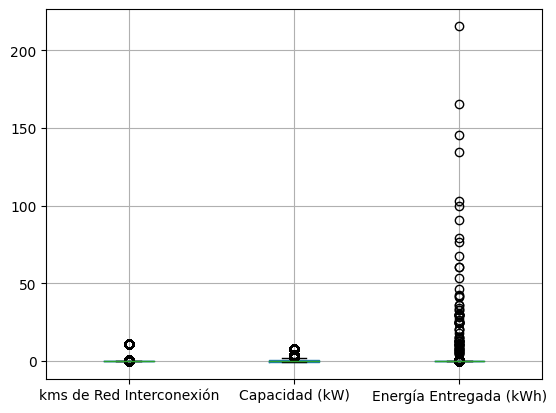

In [73]:
cuantitative_variables.boxplot()
plt.show()

Cuando hay una variable con muchos datos atípicos en un boxplot de varias variables normalizadas, como es el caso de **_Energía Entregada (kWh)_**, es probable que la escala de la variable esté sesgada o tenga una distribución no normal. Esto puede hacer que los valores extremos sean más evidentes en el gráfico, lo que hace que la mediana y los cuartiles se vean afectados. También es importante analizar por qué hay tantos valores atípicos en la variable y considerar si se deben a errores en la medición o si representan verdaderos valores extremos. Si son errores, puede ser necesario revisar la medición y los datos para corregirlos. Si son valores extremos legítimos, es posible que desee investigar por qué se produjeron y qué implicaciones tienen para su análisis.

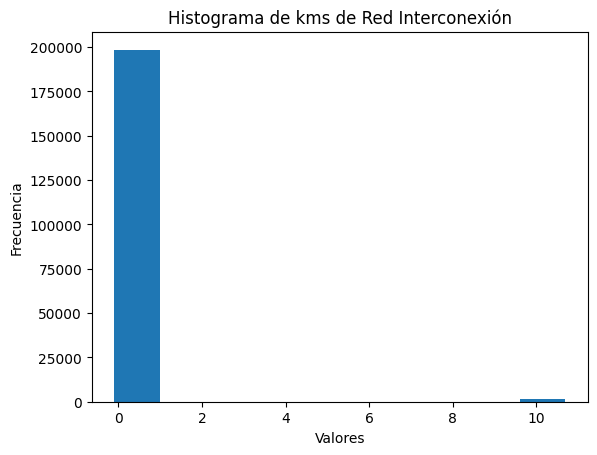

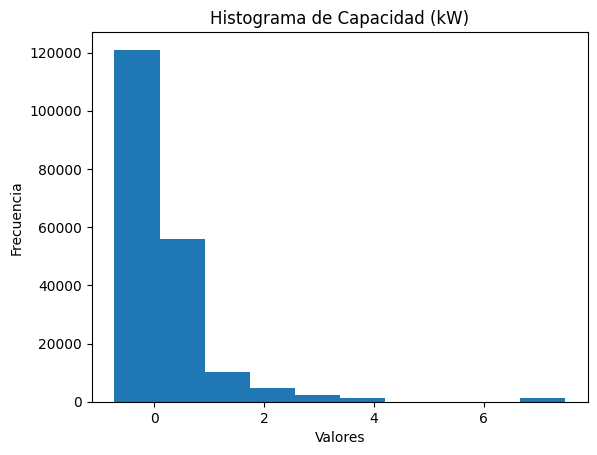

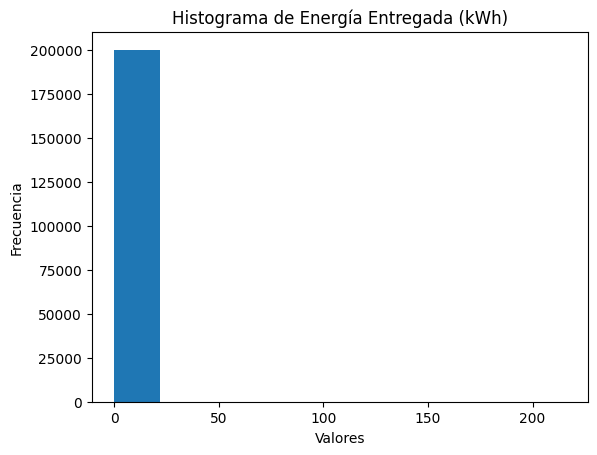

In [74]:
for col in cuantitative_variables.columns:
    plt.hist(cuantitative_variables[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

In [75]:
cualitative_variables = df[['Tipo de Tecnología', 'Horas de Servicio']].copy()
cualitative_variables['Horas de Servicio'] = pd.to_datetime(cualitative_variables['Horas de Servicio'], format='%H:%M')
cualitative_variables.head()

,Tipo de Tecnología,Horas de Servicio
0,O,1900-01-01 04:59:00
1,O,1900-01-01 04:59:00
2,O,1900-01-01 04:59:00
3,O,1900-01-01 04:59:00
4,O,1900-01-01 04:59:00


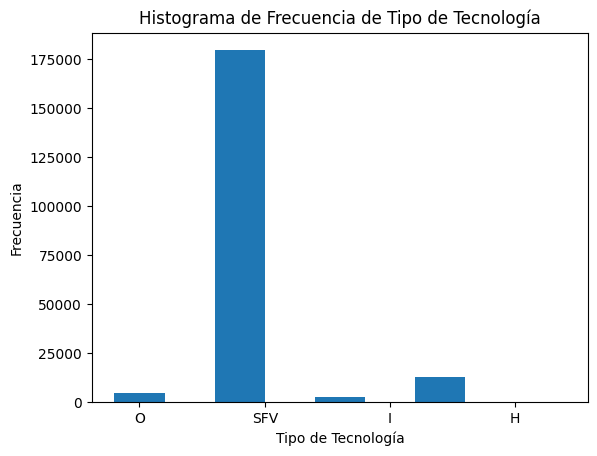

In [76]:
plt.hist(cualitative_variables['Tipo de Tecnología'], bins=len(cualitative_variables['Tipo de Tecnología'].unique()), align='left', rwidth=0.5)
plt.xlabel('Tipo de Tecnología')
plt.ylabel('Frecuencia')
plt.title('Histograma de Frecuencia de {}'.format('Tipo de Tecnología'))
plt.show()

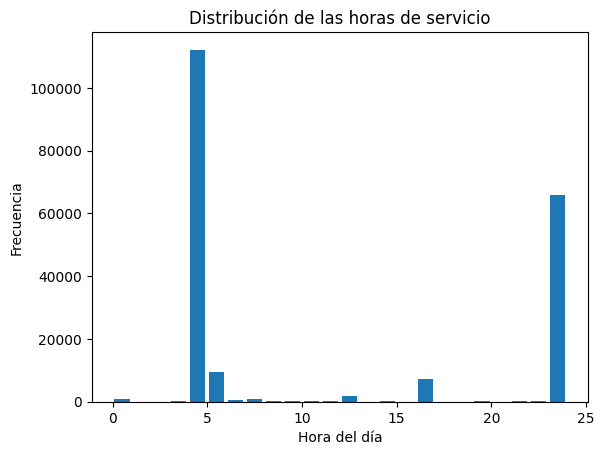

In [77]:
horas = cualitative_variables['Horas de Servicio'].apply(lambda x: x.strftime('%H:%M'))
horas_datetime = horas.apply(lambda x: datetime.strptime(x, '%H:%M'))
horas_num = horas_datetime.apply(lambda x: x.time()).apply(lambda x: x.hour + x.minute/60)
plt.hist(horas_num, bins=24, range=(0, 24), rwidth=0.8)
plt.xlabel('Hora del día')
plt.ylabel('Frecuencia')
plt.title('Distribución de las horas de servicio')
plt.show()

1. horas = cualitative_variables['Horas de Servicio'].apply(lambda x: x.strftime('%H:%M')): En esta línea, se obtiene una serie horas a partir de la columna Horas de Servicio del dataframe cualitative_variables. Se utiliza el método apply para aplicar la función lambda a cada elemento de la columna, convirtiendo los valores de fecha-hora en una cadena con formato de hora ('%H:%M').

1. horas_datetime = horas.apply(lambda x: datetime.strptime(x, '%H:%M')): Aquí, se aplica el método apply de nuevo a la serie horas para convertir las cadenas de hora en objetos de fecha-hora de Python. Esto se hace usando la función datetime.strptime y pasándole el formato '%H:%M' que se especificó previamente.

1. horas_num = horas_datetime.apply(lambda x: x.time()).apply(lambda x: x.hour + x.minute/60): En esta línea, se usa el método apply otra vez para extraer la parte de hora del objeto de fecha-hora, usando el método time() y luego convertirlo a un valor numérico. Se divide la parte de minutos por 60 para obtener la fracción de hora correspondiente, y luego se suma con la hora entera para obtener el valor numérico final. El resultado es una serie de valores numéricos que representan la hora del día.

1. plt.hist(horas_num, bins=24, range=(0, 24), rwidth=0.8): Aquí, se usa la función hist de Matplotlib para crear un histograma de los valores numéricos de horas obtenidos en el paso anterior. Se especifica que el rango de los valores es de 0 a 24 horas, y se dividen en 24 bins. La anchura de cada bin se establece en 0.8 para que no se superpongan.

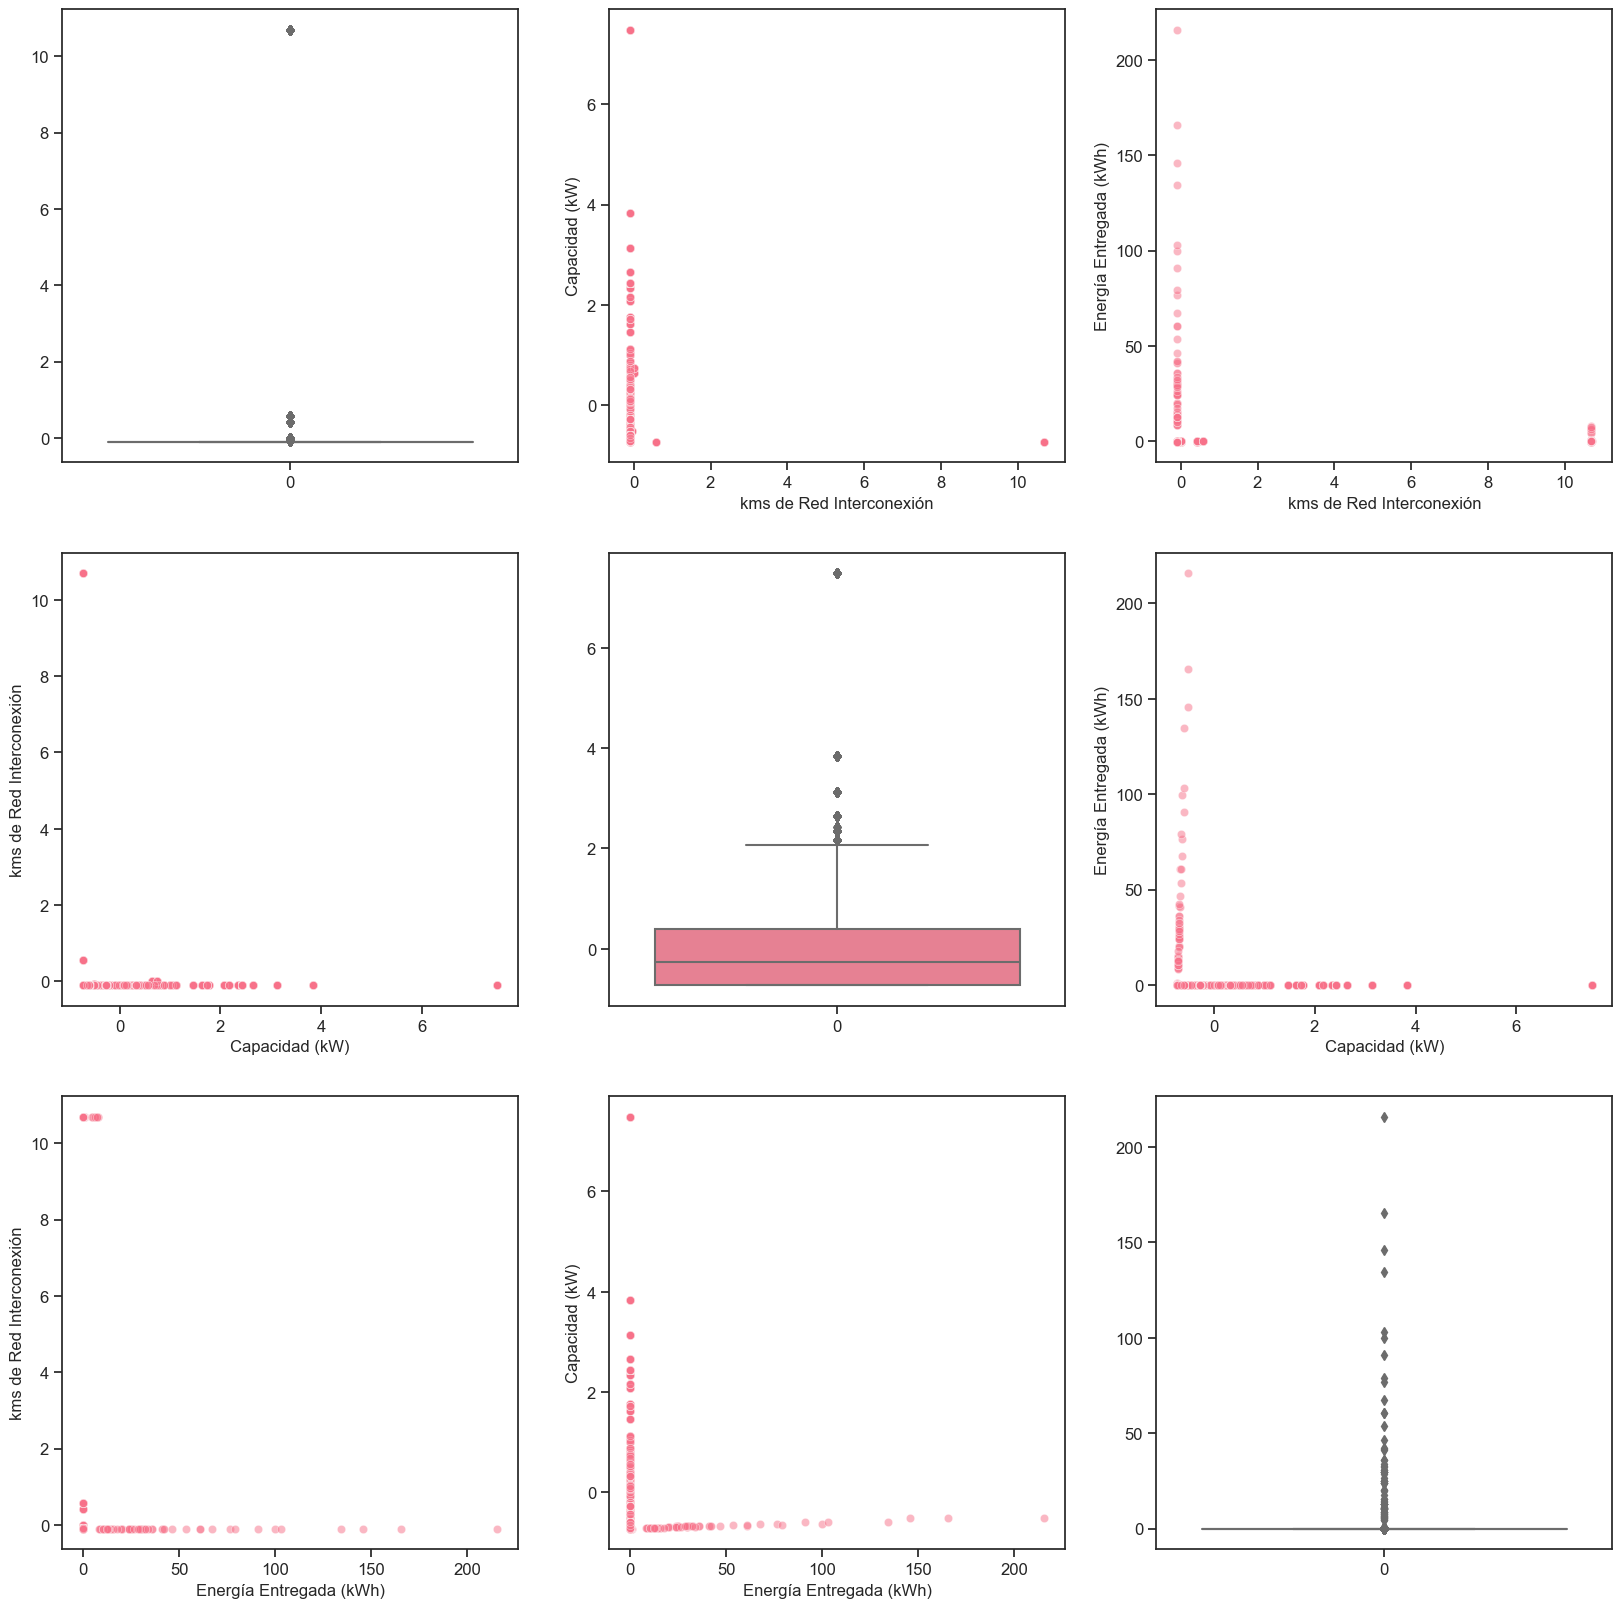

In [81]:
sns.set(style="ticks")
sns.set_palette("husl")

fig, axs = plt.subplots(ncols=len(cuantitative_variables.columns), nrows=len(cuantitative_variables.columns), figsize=(20, 20))

for i, variable in enumerate(cuantitative_variables.columns):
    for j, variable2 in enumerate(cuantitative_variables.columns):
        axs[i, j].tick_params(axis='both', labelsize=12)
        if i == j:
            sns.boxplot(cuantitative_variables[variable], ax=axs[i, j])
        else:
            sns.scatterplot(data=cuantitative_variables, x=variable, y=variable2, ax=axs[i, j], alpha=0.5)

plt.show()

Si el diagrama de dispersión aparece como dos líneas paralelas, indica que no hay una relación lineal entre las dos variables. En otras palabras, no hay una relación directa entre ellas y no se puede predecir una variable en función de la otra.

Esto podría deberse a varias razones, como por ejemplo:

- La falta de relación lineal: incluso si hay una relación entre las variables, puede que no sea lineal y, por lo tanto, no se pueda ver en un diagrama de dispersión lineal.

- La presencia de valores atípicos o influenciadores: los valores atípicos pueden tener un gran impacto en los resultados del diagrama de dispersión y pueden hacer que parezca que no hay relación entre las variables. En algunos casos, los valores atípicos pueden indicar una relación interesante que no se puede ver de otra manera, pero en otros casos pueden ser un error o una anomalía en los datos.

En resumen, si el diagrama de dispersión aparece como dos líneas paralelas, es posible que no haya una relación lineal entre las variables o que se necesiten más datos o análisis para encontrarla.

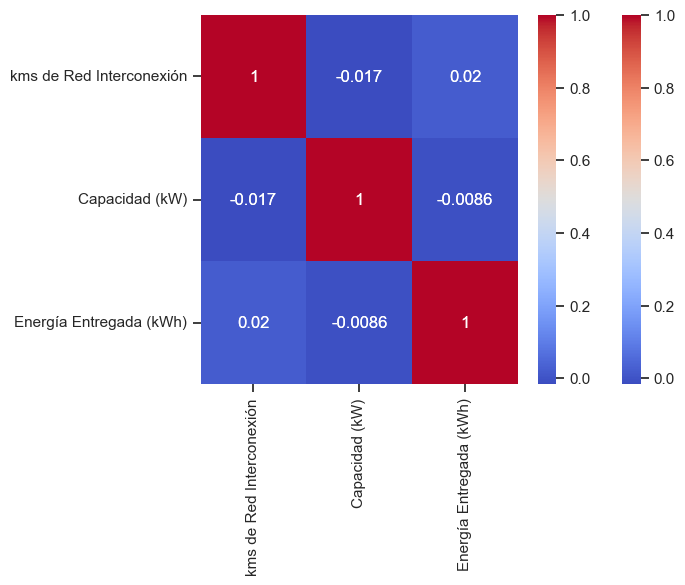

In [83]:
corr_matrix = cuantitative_variables.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

El análisis que se debe realizar es interpretar el valor del coeficiente de correlación obtenido para cada par de variables. El coeficiente de correlación puede tomar valores entre -1 y 1, donde -1 indica una correlación negativa perfecta, 0 indica ausencia de correlación y 1 indica una correlación positiva perfecta.

Si el coeficiente de correlación es cercano a 0, entonces no existe una relación lineal entre las dos variables. Si el coeficiente de correlación es mayor a 0, entonces existe una relación positiva entre las dos variables, lo que significa que a medida que una variable aumenta, también lo hace la otra. Si el coeficiente de correlación es menor a 0, entonces existe una relación negativa entre las dos variables, lo que significa que a medida que una variable aumenta, la otra disminuye.
